## Description
Author: shuheng.mo21@imperial.ac.uk (sm321@ic.ac.uk)          

This notebook contains the parallelisation of solving advection-diffusion  using multigrid method in three-dimensional space implemented with MPI (mpi4py). The script within this notebook is converted to Python scripts and presented at [here](https://github.com/ese-msc-2021/irp-sm321/tree/main/code).          


## Prerequisites

In [ ]:
## Install the required dependencies
! python -m pip install mpi4py
! mkdir serial_output
! mkdir parallel_output
! mkdir norms
! mkdir parallel_steps
! mkdir sub_domains
! mkdir test_output
! mkdir residuals
! mkdir parallel_residuals
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 7.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185272 sha256=6b19df24f18e36b846d6b7d9d33ac36aa8153593d0b3fd0a1720a4e99c5ef889
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


## Tool functions

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# view 3D result from xy, yz, xz planes
def plot_cube(result_cube, view_loc):
  fig, ax = plt.subplots(1,3, figsize=[20,5])
  plt.subplot(1,3,1)
  plt.imshow(result_cube[0,:,:,view_loc,0], cmap='jet')
  plt.colorbar()
  plt.title('central yz plane',Fontsize=20)
  plt.subplot(1,3,2)
  plt.imshow(result_cube[0,:,view_loc,:,0], cmap='jet')
  plt.colorbar()
  plt.title('central xz plane',Fontsize=20)
  plt.subplot(1,3,3)
  plt.imshow(result_cube[0,view_loc,:,:,0], cmap='jet')
  plt.colorbar()
  plt.title('central xy plane',Fontsize=20)

def plot_cube_3D(result_cube):
  # Create axis
  x,y,z = result_cube.shape
  axes = [x, y, z]

  # Create Data
  # data = np.ones(axes, dtype=np.bool)
  data = result_cube
  
  # Control Transparency
  alpha = 0.9
  
  # Control colour
  colors = np.empty(axes + [4], dtype=np.float32)
  
  colors[:] = [1, 0, 0, alpha]  # red
  
  # Plot figure
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  
  # Voxels is used to customizations of the
  # sizes, positions and colors.
  ax.voxels(data, facecolors=colors)

## Small test sample

In [ ]:
%%writefile test_example_3D.py
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

def domain_decomposition_cube(mesh, proc_grid_dim):
  nx, ny, nz = mesh.shape
  
  assert nx % proc_grid_dim[0] == 0, f"{nx} grids along x axis is not evenly divisible by {proc_grid_dim[0]}"
  assert ny % proc_grid_dim[1] == 0, f"{ny} grids along y axis is not evenly divisible by {proc_grid_dim[1]}"
  assert nz % proc_grid_dim[2] == 0, f"{nz} grids along z axis is not evenly divisible by {proc_grid_dim[2]}"
  
  sub_nx = nx // proc_grid_dim[0]
  sub_ny = ny // proc_grid_dim[1]
  sub_nz = nz // proc_grid_dim[2]

  # references: https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes
  new_shape = (sub_nx,sub_ny,sub_nz) # 6,6,6
  num_cubes = np.array(mesh.shape) // new_shape
  split_shape = np.column_stack([num_cubes, new_shape]).reshape(-1)
  order = np.array([0,2,4,1,3,5])

  return mesh.reshape(split_shape).transpose(order).reshape(-1, *new_shape)

# ==============================================================================
# mesh = np.random.randint(0,3,(2,2,2))
# mesh = np.array([[[9, 14],[80, 93]],[[61, 65],[99, 42]]])
mesh = np.array(
      [[[326, 784, 427, 308],
        [349, 428,  67, 407],
        [825, 169, 723, 464],
        [ 33, 980,  58, 241]],

       [[979, 154, 575, 435],
        [518, 407, 599, 605],
        [764,  42, 187,  10],
        [593, 318, 643, 209]],

       [[287,  48, 325, 582],
        [647, 622, 965, 954],
        [387, 129, 795, 530],
        [326, 394, 494, 756]],

       [[487, 548, 224,  86],
        [528, 685, 358, 225],
        [250, 594, 798, 434],
        [673, 797, 234, 876]]]) 

# plane values
# print('xy plane:',mesh[:,:,0])
# print('xz plane:',mesh[:,0,:])
# print('yz plane:',mesh[0,:,:])

rank = MPI.COMM_WORLD.Get_rank() # get process id
num_process = MPI.COMM_WORLD.Get_size() # get number of process
assert num_process > 1, f"Parallelisation involves 2 or more processes, otherwise run implementation without MPI"
# rows, cols = generate_dimension(0,0,num_process) 

# TODO: need a function to create cartesian processors' dimension in 3D
# we will need at least 8 processors to do the parallelization

proc_grid_dim = (2,2,2)

comm = MPI.COMM_WORLD.Create_cart(
    proc_grid_dim,
    periods=(False,False,False)
)

rank = comm.rank
proc_grid_indices = comm.Get_coords(rank)

# print("[RANK] ",rank)
# print("[PROC_IDX] ",proc_grid_indices)

LEFT = 0
RIGHT = 1
FRONT = 2
BEHIND = 3
TOP = 4
BOTTOM = 5
neighbors = [0, 0, 0, 0, 0, 0] # processor rank of all neighbors

# find neighbors (note here 0,1,2 are x,y,z coordinates respectively)
neighbors[LEFT], neighbors[RIGHT] = comm.Shift(2, 1)
neighbors[FRONT],  neighbors[BEHIND]  = comm.Shift(1, 1)
neighbors[BOTTOM],  neighbors[TOP]  = comm.Shift(0, 1)

# level 1 
# 0 + 1
# 2 + 3
# level 2
# 4 + 5
# 6 + 7

print("[NEIGHBORS of {}] ".format(rank),neighbors)

# this should return 8 smaller cubes with shape (6,6,6)
sub_cubes = domain_decomposition_cube(mesh, proc_grid_dim) # x/2, y/2,z/2
current_cube = sub_cubes[rank]

# use datatypes with 64 bits (Not working for 3D case?)
# comm_datatype_3D = MPI.DOUBLE.Create_subarray(subcube_size, cube_size, start_indices)
# comm_datatype_3D.Commit()

# generate sub cube for calculation: added the halo grids to subdomain
current_cube = np.pad(current_cube,(1,1),'constant',constant_values=(0,))
# print("[CURRENT SHAPE of {}]".format(rank), current_cube.shape)

## halo update once
# FRONT AND BEHIND
front_buffer = np.copy(np.ascontiguousarray(current_cube[1:-1, 1, 1:-1]))
behind_buffer = np.copy(np.ascontiguousarray(current_cube[1:-1, -2, 1:-1]))
comm.Sendrecv_replace(front_buffer,neighbors[FRONT],0,neighbors[FRONT],1)
comm.Sendrecv_replace(behind_buffer,neighbors[BEHIND],1,neighbors[BEHIND],0)

if neighbors[FRONT] != -2:
  current_cube[1:-1,0,1:-1] = front_buffer
if neighbors[BEHIND] != -2:
  current_cube[1:-1,-1,1:-1] = behind_buffer

# LEFT AND RIGHT
left_buffer = np.copy(np.ascontiguousarray(current_cube[:, :, 1]))
right_buffer = np.copy(np.ascontiguousarray(current_cube[:, :, -2]))
comm.Sendrecv_replace(left_buffer,neighbors[LEFT],2,neighbors[LEFT],3)
comm.Sendrecv_replace(right_buffer,neighbors[RIGHT],3,neighbors[RIGHT],2)

# Update the left and right
if neighbors[LEFT] != -2:
  current_cube[:,:,0] = left_buffer
if neighbors[RIGHT] != -2:
  current_cube[:,:,-1] = right_buffer

#TOP AND BOTTOM
top_buffer = np.copy(np.ascontiguousarray(current_cube[-2,:,:]))
bottom_buffer = np.copy(np.ascontiguousarray(current_cube[1,:,:]))
comm.Sendrecv_replace(top_buffer,neighbors[TOP],4,neighbors[TOP],5)
comm.Sendrecv_replace(bottom_buffer,neighbors[BOTTOM],5,neighbors[BOTTOM],4)

if neighbors[TOP] != -2:
  current_cube[-1,:,:] = top_buffer
if neighbors[BOTTOM] != -2:
  current_cube[0,:,:] = bottom_buffer

del top_buffer,bottom_buffer,left_buffer,right_buffer,front_buffer,behind_buffer

# print(current_cube.shape)

np.save("/content/test_output/current_domain_{}.npy".format(rank), current_cube)

Overwriting test_example_3D.py


In [ ]:
! mpiexec --allow-run-as-root -n 8 python test_example_3D.py

[NEIGHBORS of 0]  [-2, 1, -2, 2, 4, -2]
[NEIGHBORS of 4]  [-2, 5, -2, 6, -2, 0]
[NEIGHBORS of 1]  [0, -2, -2, 3, 5, -2]
[NEIGHBORS of 5]  [4, -2, -2, 7, -2, 1]
[NEIGHBORS of 3]  [2, -2, 1, -2, 7, -2]
[NEIGHBORS of 7]  [6, -2, 5, -2, -2, 3]
[NEIGHBORS of 2]  [-2, 3, 0, -2, 6, -2]
[NEIGHBORS of 6]  [-2, 7, 4, -2, -2, 2]


(4, 4, 4)


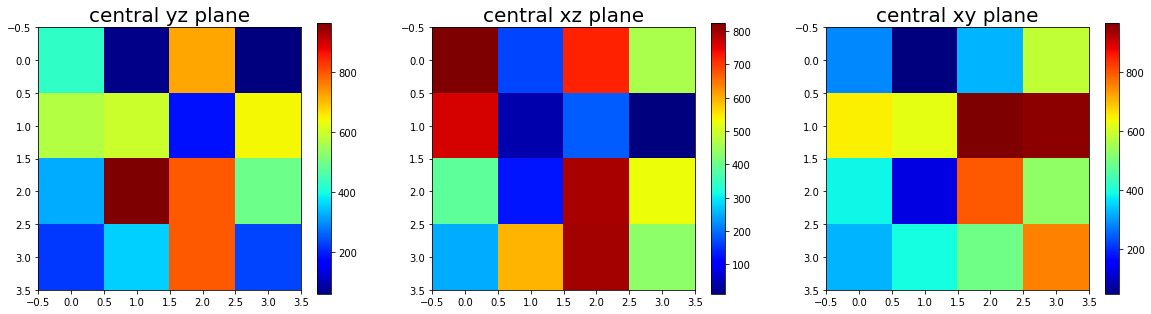

In [ ]:
mesh = np.array(
      [[[326, 784, 427, 308],
        [349, 428,  67, 407],
        [825, 169, 723, 464],
        [ 33, 980,  58, 241]],

       [[979, 154, 575, 435],
        [518, 407, 599, 605],
        [764,  42, 187,  10],
        [593, 318, 643, 209]],

       [[287,  48, 325, 582],
        [647, 622, 965, 954],
        [387, 129, 795, 530],
        [326, 394, 494, 756]],

       [[487, 548, 224,  86],
        [528, 685, 358, 225],
        [250, 594, 798, 434],
        [673, 797, 234, 876]]]) 

print(mesh.shape)

plot_cube(mesh.reshape(1,4,4,4,1),2)

(4, 4, 4)
(8, 8, 8)
[[[  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]
  [  0   0   0   0]]

 [[  0   0   0   0]
  [  0 326 784 427]
  [  0 349 428  67]
  [  0 825 169 723]]

 [[  0   0   0   0]
  [  0 979 154 575]
  [  0 518 407 599]
  [  0 764  42 187]]

 [[  0   0   0   0]
  [  0 287  48 325]
  [  0 647 622 965]
  [  0 387 129 795]]]


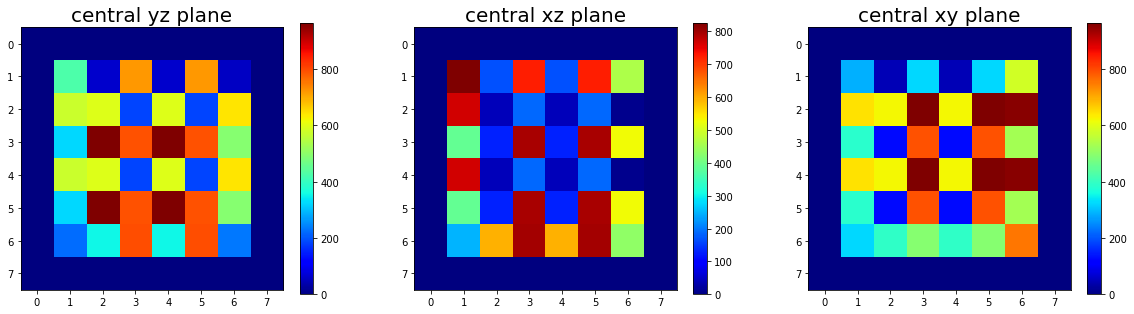

In [ ]:
test_result_1 = np.load("/content/test_output/current_domain_0.npy")
test_result_2 = np.load("/content/test_output/current_domain_1.npy")
test_result_3 = np.load("/content/test_output/current_domain_2.npy")
test_result_4 = np.load("/content/test_output/current_domain_3.npy")
test_result_5 = np.load("/content/test_output/current_domain_4.npy")
test_result_6 = np.load("/content/test_output/current_domain_5.npy")
test_result_7 = np.load("/content/test_output/current_domain_6.npy")
test_result_8 = np.load("/content/test_output/current_domain_7.npy")

temp1 = np.concatenate([test_result_1,test_result_2], axis = 2)
temp2 = np.concatenate([test_result_3,test_result_4], axis = 2)
level_1 = np.concatenate([temp1, temp2], axis = 1)

temp3 = np.concatenate([test_result_5,test_result_6], axis = 2)
temp4 = np.concatenate([test_result_7,test_result_8], axis = 2)
level_2 = np.concatenate([temp3, temp4], axis = 1)

merged_domain = np.concatenate([level_1,level_2], axis=0)
print(test_result_1.shape)
print(merged_domain.shape)
# plot_cube(merged_domain.reshape(1,8,8,8,1),2)

fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(merged_domain[:,:,3], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(merged_domain[:,3,:], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(merged_domain[3,:,:], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)
print(test_result_1)

## Problem Details
Recall the [CFD model](https://www.imperial.ac.uk/people/c.heaney/document/9723/AI_for_CFD_v1b/?AI_for_CFD_v1b.pdf) Boyang et al. have implemented for solving 2D advection-diffusion equation, Burger equation with TensorFlow. Based on the idea in the proceeding work, here we apply multi-grid method to solve advection-diffusion equation in 3D space.           

$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x}+ v\frac{\partial T}{\partial y} = \nu \nabla^2T $.  (e.g. 2D Advection- diffusion equation)          

Now we consider:
Using 7-stencil and multigrid method to solve a advection-diffusion problem in 3D space. In this problem, we have a constant heat source located in the centre of the cube and observe the movement of it with respect to the time.

$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x}+ v\frac{\partial T}{\partial y} = \nu \nabla^2T $.  (e.g. 3D Advection- diffusion equation in steady-state)   

<!-- in which T is a scalar concentration field with size 300m by 300m,$t$ is time, ($u,v$) are the advection velocities.$\sigma$,$\nu$ and $s$ respectively are the absorption term, constant diffusivity and source term. Boundary conditions fixed zero solutions at the edges of the domain (No-flux boundary condition). Note for the equation formulated in this work, $\sigma = s = 0$ and advection velocity is fixed with ($1ms^{-1},1ms^{-1}$). So the expected pattern for those two initialised distributions are to be advected to the upper-right corner while diffused with constant coefficient. -->

## Serial implementation

### Initial condition

values.shape:  (1, 128, 128, 128, 1)


Text(0.5, 1.0, 'central xy plane')

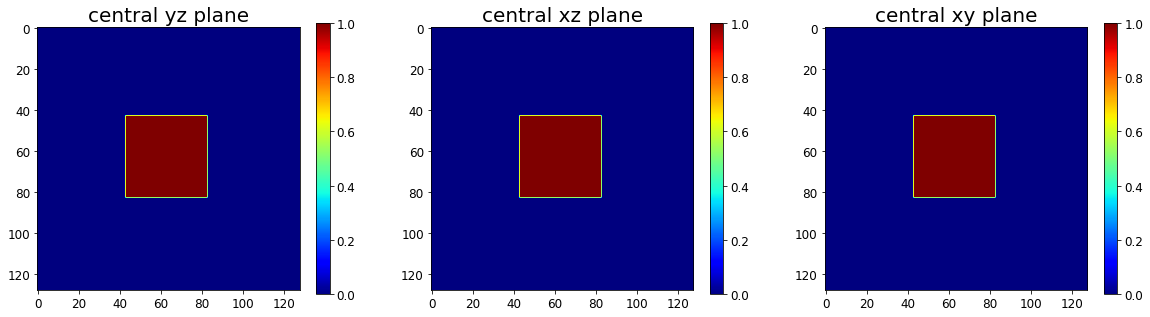

In [ ]:
import numpy as np 
import math
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

dt = 0.1
dx = 1 
Dx = 100.0
Dy = 100.0
Dz = 100.0
# what are these terms in diff dimesions?
ub = 500 # what is this term? 

# the weights matrix (in 3D)
alpha = 1 # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 128
ny = 128
nz = 128

T = np.zeros([nx,ny,nz]) # problem space (128,128,128)
gamma = 10
# initialise t:
x0 = 0 
y0 = 0
z0 = 0
x = np.zeros([1,nx])
y = np.zeros([1,ny])
z = np.zeros([1,nz])

# generate the constant heat source
for ii in range(nx):
    x[0][ii] = -63.5 + 128/nx*ii
    y[0][ii] = -63.5 + 128/nx*ii    
    z[0][ii] = -63.5 + 128/nx*ii

for i in range(40):
    for j in range(40):
        for k in range(40):
            T[i+43][j+43][k+43] = 1 

input_shape = (1,nx,ny,nz,1)
values = tf.zeros(input_shape)
print('values.shape: ', values.shape)

temp1 = tf.Variable(values)
temp1[0,:,:,:,0].assign(temp1[0,:,:,:,0]+tf.convert_to_tensor(T.astype('float32')))
values = temp1

# we can see the result is close to matrix size 64
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(values[0,:,:,63,0],cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(values[0,:,63,:,0],cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(values[0,63,:,:,0],cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Serial multigrid 3D

In [ ]:
#============================== Imports ==================================#

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import math
import time

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

#============================== Initialization of problem ==================================#
dx = 1       # Grid size in x    
dy = 1       # Grid size in y       
dz = 1       # Grid size in z    
Dx = 100.0   # Conductivity in x    
Dy = 100.0   # Conductivity in y
Dz = 100.0    # Conductivity in z
# Parameters for the computational domain
alpha = 1    # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 128     # Grid point in x
ny = 128     # Grid point in y
nz = 128     # Grid point in z

# the weights matrix
w1 = np.zeros([1,2,2,2,1])
w2 = np.zeros([1,3,3,3,1])
w1[0,:,:,:,0] = 0.125
pd1 = [[0.0, 0.0,  0.0],
       [0.0, 1.0*Dz/dz**2,  0.0],
       [0.0, 0.0,  0.0]]
pd2 = [[0.0, 1.0*Dy/dy**2,  0.0],
       [1.0*Dx/dx**2,  -(2*Dx/dx**2+2*Dy/dy**2+2*Dz/dz**2),  1.0*Dx/dx**2],
       [0.0, 1.0*Dy/dy**2,  0.0]]
pd3 = [[0.0, 0.0,  0.0],
       [0.0, 1.0*Dz/dz**2,  0.0],
       [0.0, 0.0,  0.0]]
w2[0,0,:,:,0] = -np.array(pd1) 
w2[0,1,:,:,0] = -np.array(pd2) 
w2[0,2,:,:,0] = -np.array(pd3) 

#============================== Initialization CNN layers ==================================#
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)) )

# CNN layers
CNN3D_A_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

#============================== Restriction process ==================================#
CNN3D_res_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),   
])    
CNN3D_res_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])


#============================== Prolongation process ==================================#
# good prolongation was based on good guess on the coarse space
# or maybe we can see these as interpolation
CNN3D_prol_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

CNN3D_prol_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)), 
])

CNN3D_prol_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

CNN3D_prol_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

#============================== Initial Condition ==================================#
import math
T = np.zeros([nx,ny,nz]) # problem space (128,128,128)
gamma = 10
# initialise t:
x0 = 0 
y0 = 0
z0 = 0
x = np.zeros([1,nx])
y = np.zeros([1,ny])
z = np.zeros([1,nz])

for i in range(40):
    for j in range(40):
        for k in range(40):
            T[i+43][j+43][k+43] = 1 

input_shape = (1,nx,ny,nz,1)
values = tf.zeros(input_shape,dtype=tf.float32)
print('values.shape: ', values.shape)

#============================== Skipping layer ==================================#

start_time = time.perf_counter()
temp1 = tf.Variable(values)
temp1[0,:,:,:,0].assign(temp1[0,:,:,:,0]+tf.convert_to_tensor(T.astype('float32')))
values = temp1
b = values # only for one time step
multi_itr = 100
j_itr = 1 # Jacobi iteration number
for multi_grid in range(multi_itr):    
    w_2 = np.zeros([1,2,2,2,1])
    r = CNN3D_A_128(values) - b # compute the residual errors

    # the restriction           
    r_64 = CNN3D_res_128(r) #32
    r_32 = CNN3D_res_64(r_64) #16
    r_16 = CNN3D_res_32(r_32) #8
    r_8 = CNN3D_res_16(r_16) #4
    r_4 = CNN3D_res_8(r_8) #2
    r_2 = CNN3D_res_4(r_4) #1 for the parallel
    # r_1 = CNN3D_res_2(r_2)

    np.save("/content/residuals/serial_residual",r_2)

    # I suppose here is the proess of Jacobi smoothing followed by prolongation (and correction)
    # for Jacobi in range(j_itr):
        # w = w - CNN3D_A_1(w)/w2[0,1,1,1,0] + r_1/w2[0,1,1,1,0]

    # w = w - CNN3D_A_1(w)/w2[0,1,1,1,0] + r_1/w2[0,1,1,1,0]

    # w_2 = CNN3D_prol_1(w)                   
    for Jacobi in range(j_itr):
        w_2 = w_2 - CNN3D_A_2(w_2)/w2[0,1,1,1,0] + r_2/w2[0,1,1,1,0]
    
    w_2 = w_2 - CNN3D_A_2(w_2)/w2[0,1,1,1,0] + r_2/w2[0,1,1,1,0]
    # print(tf.reshape(w_2,(2,2,2)))

    # np.save("/content/residuals/serial_residual",r_2)

    w_4 = CNN3D_prol_2(w_2) 
    # print(tf.reshape(w_4,(4,4,4)))
    for Jacobi in range(j_itr):
        w_4 = w_4 - CNN3D_A_4(w_4)/w2[0,1,1,1,0] + r_4/w2[0,1,1,1,0]

    # print(tf.reshape(w_4,(4,4,4)))

    # np.save("/content/residuals/serial_residual",w_4)

    w_8 = CNN3D_prol_4(w_4) 
    for Jacobi in range(j_itr):
        w_8 = w_8 - CNN3D_A_8(w_8)/w2[0,1,1,1,0] + r_8/w2[0,1,1,1,0]

    w_16 = CNN3D_prol_8(w_8) 
    for Jacobi in range(j_itr):
        w_16 = w_16 - CNN3D_A_16(w_16)/w2[0,1,1,1,0] + r_16/w2[0,1,1,1,0]

    w_32 = CNN3D_prol_16(w_16) 
    for Jacobi in range(j_itr):
        w_32 = w_32 - CNN3D_A_32(w_32)/w2[0,1,1,1,0] + r_32/w2[0,1,1,1,0]
    
    w_64 = CNN3D_prol_32(w_32)
    for Jacobi in range(j_itr):
        w_64 = w_64 - CNN3D_A_64(w_64)/w2[0,1,1,1,0] + r_64/w2[0,1,1,1,0]
    
    w_128 = CNN3D_prol_64(w_64)
    w_128 = w_128 - CNN3D_A_128(w_128)/w2[0,1,1,1,0] + r/w2[0,1,1,1,0]

    values = values - w_128 
    values = values - CNN3D_A_128(values)/w2[0,1,1,1,0] + b/w2[0,1,1,1,0]

end_time = time.perf_counter()
# save final result and the prolongation
np.save("/content/serial_output/serial_AD_multigrid_3D_result.npy",values)
np.save("/content/serial_output/serial_AD_multigrid_3D_w2.npy",w_2)
np.save("/content/serial_output/serial_AD_multigrid_3D_w4.npy",w_4)
np.save("/content/serial_output/serial_AD_multigrid_3D_w8.npy",w_8)
np.save("/content/serial_output/serial_AD_multigrid_3D_w16.npy",w_16)
np.save("/content/serial_output/serial_AD_multigrid_3D_w32.npy",w_32)
np.save("/content/serial_output/serial_AD_multigrid_3D_w64.npy",w_64)
np.save("/content/serial_output/serial_AD_multigrid_3D_w128.npy",w_128)

print(f"[INFO] Problem solved in {end_time - start_time:0.4f} seconds using serial multigrid.")
# [INFO] Problem solved in 1454.7491 seconds using serial multigrid. (cpu time)
# around 200 seconds

values.shape:  (1, 128, 128, 128, 1)
[INFO] Problem solved in 10.9032 seconds using serial multigrid.


## MPI Subroutine

In [ ]:
%%writefile halo_exchange.py
# imports
import sys
import numpy as np  # cupy can be used as optimisation if CUDA/AMD GPUs are available
from tensorflow import keras
import tensorflow as tf
from mpi4py import MPI

assert tf.__version__ >= "2.0"
np.set_printoptions(threshold=sys.maxsize)  # print out the full numpy array

############################## Global variables ################################
comm = None               # MPI communicator
rank = 0                  # Process rank
num_process = 1           # Number of processors
rows, cols = 1, 1           # Cartesian topology for 2D structured mesh
sub_nx, sub_ny, sub_nz = 0, 0, 0  # Dimensions for sub-domain up to 3D
# Process rank for all neighboring subdomains
neighbors = [-2, -2, -2, -2, -2, -2]
current_vector = None     # 1D Block structured sub-domain
current_domain = None     # 2D Block Structured sub-domain
current_cube = None       # 3D Block Structured sub-domain
# variable control the precision of MPI communication buffer vlaues
is_double_precision = False
is_diagonal_exchange = False  # control do we need exchange values on corners

# TODO: the best practice is to use OOP
# class halo_exchange:
#   # initialization
#   def __init__(self) -> None:

#   # member functions

############################## Util functions ##################################
# clear the cached subdomain to release memory


def clear_cache():
    global current_domain, current_cube
    if current_domain != None:
        del current_domain
    if current_cube != None:
        del current_cube


def id_2_idx(rank, cols):
    """
    return the indices of processor in processor
    grid space based on the processor ranks

    Parameters
    ----------
    rank : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    return rank/cols, rank % cols


def idx_2_id(rows, cols, id_row, id_col):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    if id_row >= rows or id_row < 0:
        return -1
    if id_col >= cols or id_col < 0:
        return -1
    return id_row * id_col + id_col


def generate_dimension_2D(num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    global rows, cols
    rows, cols = 0, 0
    min_gap = num_process
    max_val = int(num_process**0.5 + 1)
    for i in range(1, max_val+1):
        if num_process % i == 0:
            gap = abs(num_process/i - i)
            if gap < min_gap:
                min_gap = gap
                rows = i
                cols = int(num_process / i)

    return rows, cols


def generate_dimension_3D(num_process):
    # TODO: generate dimension for 3D processor grid space
    pass


def domain_decomposition_strip(mesh, num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    sub_domains = np.hsplit(mesh, num_process)
    return sub_domains


def domain_decomposition_grid(mesh, rows, cols):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    nx, ny = mesh.shape
    assert nx % rows == 0, f"{nx} rows is not evenly divisible by {rows}"
    assert ny % cols == 0, f"{ny} cols is not evenly divisible by {cols}"
    sub_nx = nx//rows
    sub_ny = ny//cols
    return (mesh.reshape(nx//sub_nx, sub_nx, -1, sub_ny)
            .swapaxes(1, 2)
            .reshape(-1, sub_nx, sub_ny))


def domain_decomposition_cube(mesh, proc_grid_dim):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    global sub_nx, sub_ny, sub_nz
    nx, ny, nz = mesh.shape

    assert nx % proc_grid_dim[0] == 0, f"{nx} grids along x axis is not evenly divisible by {proc_grid_dim[0]}"
    assert ny % proc_grid_dim[1] == 0, f"{ny} grids along y axis is not evenly divisible by {proc_grid_dim[1]}"
    assert nz % proc_grid_dim[2] == 0, f"{nz} grids along z axis is not evenly divisible by {proc_grid_dim[2]}"

    sub_nx = nx // proc_grid_dim[0]
    sub_ny = ny // proc_grid_dim[1]
    sub_nz = nz // proc_grid_dim[2]

    new_shape = (sub_nx, sub_ny, sub_nz)
    num_cubes = np.array(mesh.shape) // new_shape
    split_shape = np.column_stack([num_cubes, new_shape]).reshape(-1)
    order = np.array([0, 2, 4, 1, 3, 5])

    # return a numpy array
    return mesh.reshape(split_shape).transpose(order).reshape(-1, *new_shape)


def find_neighbours_id_2D(rank, rows, cols, proc_row_idx, proc_col_idx, num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    # TODO: Consider the conditions in periodic boundaries (if required)
    # left,right,top,bottom = find_neighbours_id(rank,rows,cols,proc_row_idx,proc_col_idx,num_process)
    # print("[INFO] Neighbors of process {}: left={},right={},up={},down={}".format(rank,left,right,top,bottom))
    left_neighbour = (
        rank - 1) if proc_col_idx != 0 and rank >= 1 else MPI.PROC_NULL
    right_neighbour = (rank + 1) if proc_col_idx != (cols -
                                                     1) and rank < num_process - 1 else MPI.PROC_NULL
    top_neighbour = (
        rank - cols) if proc_row_idx != 0 and (rank - cols) >= 0 else MPI.PROC_NULL
    bottom_neighbour = (rank + cols) if proc_row_idx != (rows -
                                                         1) and (rank + cols) <= num_process-1 else MPI.PROC_NULL

    return left_neighbour, right_neighbour, top_neighbour, bottom_neighbour

# padding halos to sub-domain manually


def padding_block_halo_1D(sub_domain, halo_size, halo_val=0):
    """_summary_

    Args:
        sub_domain (_type_): _description_
        halo_size (_type_): _description_
        halo_val (int, optional): _description_. Defaults to 0.

    Returns:
        _type_: _description_
    """
    if tf.is_tensor(sub_domain):
        sub_domain = sub_domain.numpy()

    if sub_domain.ndim > 1:
        sub_domain = np.squeeze(sub_domain, axis=0)
        sub_domain = np.squeeze(sub_domain, axis=-1)

    return np.pad(sub_domain, (halo_size, halo_size), 'constant', constant_values=(halo_val,))


def padding_block_halo_2D(sub_domain, halo_size, halo_val=0):
    """_summary_

    Args:
        sub_domain (_type_): _description_
        halo_size (_type_): _description_
        halo_val (int, optional): _description_. Defaults to 0.

    Returns:
        _type_: _description_
    """
    if tf.is_tensor(sub_domain):
        sub_domain = sub_domain.numpy()

    if sub_domain.ndim > 2:
        sub_domain = np.squeeze(sub_domain)

    # note padding halo values with 0 by default
    return np.pad(sub_domain, (halo_size, halo_size), 'constant', constant_values=(halo_val,))

# incase we need diff size of halos on each boudary


def padding_block_halo_2D_custom(sub_domain, halo_dim, halo_vals):
    pass


def padding_block_halo_3D(sub_cube, halo_size, halo_val=0):
    """_summary_

    Args:
        sub_cube (_type_): _description_
        halo_size (_type_): _description_
        halo_val (int, optional): _description_. Defaults to 0.

    Returns:
        _type_: _description_
    """
    if tf.is_tensor(sub_cube):
        sub_cube = sub_cube.numpy()

    if sub_cube.ndim > 3:
        sub_cube = remove_one_dims(sub_cube)

    nx, ny, nz = sub_cube.shape

    # note padding halo values with 0 by default
    ans = np.pad(sub_cube, (halo_size, halo_size),
                 'constant', constant_values=(halo_val,))
    return tf.convert_to_tensor(ans.reshape(1, nx+2, ny+2, nz+2, 1))

# incase we need diff size of halos on each boudary


def padding_block_halo_3D_custom(sub_cube, halo_dim, halo_vals):
    pass


# remove trivial 1 dimensions of the tensor.numpy()
def remove_one_dims(input):
    """_summary_

    Args:
        input (_type_): _description_

    Returns:
        _type_: _description_
    """
    while input.ndim > 3:
        if input.shape[0] == 1:
            input = np.squeeze(input, axis=0)
        if input.shape[-1] == 1:
            input = np.squeeze(input, axis=-1)
    return input

############################## MPI Initialization ##############################


def mpi_initialization(proc_grid_dim, is_periodic, is_reordered):
    """_summary_

    Args:
        proc_grid_dim (_type_): _description_
        is_periodic (bool): _description_
        is_reordered (bool): _description_

    Returns:
        _type_: _description_
    """
    global rank, num_process, comm

    num_process = MPI.COMM_WORLD.Get_size()  # get number of process
    assert num_process > 1, f"Parallelisation involves 2 or more processes, otherwise run implementation without MPI"

    # create Cartesian Topology
    comm = MPI.COMM_WORLD.Create_cart(
        proc_grid_dim,
        periods=is_periodic,  # set True if periodic boundary
        reorder=is_reordered)

    # get the rank of current process
    rank = comm.rank


def domain_decomposition_1D(values, nx, is_periodic=False, is_reordered=True):
    """_summary_

    Args:
        values (_type_): _description_
        nx (_type_): _description_
        is_periodic (bool, optional): _description_. Defaults to False.
        is_reordered (bool, optional): _description_. Defaults to True.

    Returns:
        _type_: _description_
    """
    global num_process, comm, rank, sub_nx, neighbors, current_vector
    LEFT = 0
    RIGHT = 1

    num_process = MPI.COMM_WORLD.Get_size()  # get number of process
    proc_grid_dim = (num_process,)
    mpi_initialization(proc_grid_dim, is_periodic, is_reordered)

    neighbors[LEFT], neighbors[RIGHT] = comm.Shift(0, 1)

    # print("NEIGHBORS OF {} ".format(rank),neighbors)

    sub_domains = domain_decomposition_strip(
        values.reshape(nx,), num_process)  # (1,x)
    sub_nx = sub_domains[rank].shape[0]
    current_vector = np.pad(
        sub_domains[rank], (1, 1), "constant", constant_values=(0,))

    return sub_nx, current_vector

# grid decomposition for 2D block structured meshes


def domain_decomposition_2D(values, nx, ny, is_periodic=(False, False), is_reordered=True):
    """_summary_

    Args:
        values (_type_): _description_
        nx (_type_): _description_
        ny (_type_): _description_
        is_periodic (tuple, optional): _description_. Defaults to (False, False).
        is_reordered (bool, optional): _description_. Defaults to True.

    Returns:
        _type_: _description_
    """
    global comm, rank, sub_nx, sub_ny, neighbors, current_domain

    TOP = 0
    BOTTOM = 1
    LEFT = 2
    RIGHT = 3

    num_process = MPI.COMM_WORLD.Get_size()  # get number of process
    proc_grid_dim = generate_dimension_2D(num_process)
    mpi_initialization(proc_grid_dim, is_periodic, is_reordered)

    if rows == 1 or cols == 1:
        sub_domains = domain_decomposition_strip(
            values.reshape(nx, ny), num_process)  # 2 process
        sub_nx, sub_ny = sub_domains[0].shape
    else:
        # if the process arrays is 2D then use grid decomposition to split domain
        sub_domains = domain_decomposition_grid(
            values.reshape(nx, ny), rows, cols)
        sub_nx, sub_ny = sub_domains[0].shape

    # create customized MPI datatype
    # grid_size = [sub_nx, sub_ny]
    # subdomain_size = [sub_nx+2, sub_ny + 2]
    # start_indices = [1, 1]

    # customised data type for 2D problem
    # comm_datatype = MPI.DOUBLE.Create_subarray(subdomain_size, grid_size, start_indices).Commit()

    # find the processor id of all neighboring processors
    neighbors[TOP], neighbors[BOTTOM] = comm.Shift(0, 1)
    neighbors[LEFT],  neighbors[RIGHT] = comm.Shift(1, 1)

    current_domain = np.pad(
        sub_domains[rank], (1, 1), "constant", constant_values=(0,))

    return sub_nx, sub_ny, current_domain

# grid decomposition for 3D block structured meshes


def domain_decomposition_3D(values, nx, ny, nz, is_periodic=(False, False, False), is_reordered=True):
    """_summary_

    Args:
        values (_type_): _description_
        nx (_type_): _description_
        ny (_type_): _description_
        nz (_type_): _description_
        is_periodic (tuple, optional): _description_. Defaults to (False, False, False).
        is_reordered (bool, optional): _description_. Defaults to True.

    Returns:
        _type_: _description_
    """
    global rank, num_process, neighbors, current_cube

    # neighbor indices
    LEFT = 0
    RIGHT = 1
    FRONT = 2
    BEHIND = 3
    TOP = 4
    BOTTOM = 5

    num_process = MPI.COMM_WORLD.Get_size()  # get number of process
    # TODO: create Cartesian topology for processes in 3D space
    proc_grid_dim = (2, 2, 2)  # divide to 2x2x2, 8 subcubes
    # proc_grid_dim = (4,4,4) # divide to 4x4x4, 64 subcubes
    mpi_initialization(proc_grid_dim, is_periodic, is_reordered)

    # edge case, if 1 process we do nothing
    if num_process == 1:
        return nx, ny, nz, values

    if tf.is_tensor(values):
        sub_cubes = domain_decomposition_cube(tf.reshape(
            values, [nx, ny, nz]).numpy(), proc_grid_dim)
        # we can do this in complete tensorflow routines
        # current_cube = tf.convert_to_tensor(sub_cubes[rank], dtype=tf.float32)
        # paddings = tf.constant([[1, 1], [1, 1], [1, 1]])
        # current_cube = tf.pad(current_cube, paddings)
    else:
        sub_cubes = domain_decomposition_cube(values.reshape(
            nx, ny, nz), proc_grid_dim)  # if it is numpy reshape directly

    # create customized MPI datatype
    # cube_size = [sub_nx, sub_ny, sub_nz]
    # subcube_size = [sub_nx+2, sub_ny + 2, sub_nz + 2]
    # start_indices = [1, 1, 1]

    # use datatypes with 64 bits
    # comm_datatype_3D = MPI.DOUBLE.Create_subarray(subcube_size, cube_size, start_indices).Commit()

    # padding the halo grids
    current_cube = np.pad(
        sub_cubes[rank], (1, 1), 'constant', constant_values=(0,))

    # print("[CURRENT_CUBE_SHAPE of {}]".format(rank), current_cube.shape)

    # find neighbors (note here 0,1,2 are x,y,z coordinates respectively)
    neighbors[LEFT], neighbors[RIGHT] = comm.Shift(2, 1)
    neighbors[FRONT],  neighbors[BEHIND] = comm.Shift(1, 1)
    neighbors[BOTTOM],  neighbors[TOP] = comm.Shift(0, 1)

    # print("[NEIGHBORS of {}] ".format(rank),neighbors)

    # return tf.convert_to_tensor(current_cube,np.float64)
    return sub_nx, sub_ny, sub_nz, current_cube


def structured_halo_update_1D(input_vector):
    """_summary_

    Args:
        input_vector (_type_): _description_

    Returns:
        _type_: _description_
    """
    global comm, neighbors, current_vector, sub_nx

    if tf.is_tensor(input_vector):
        current_vector = input_vector.numpy()
    else:
        current_vector = input_vector

    if current_vector.ndim > 1:
        current_vector = np.squeeze(current_vector, axis=0)
        current_vector = np.squeeze(current_vector, axis=-1)

    #print("reduced shape: ",current_vector.shape)

    LEFT = 0
    RIGHT = 1

    sub_nx = current_vector.shape[0]

    send_left = np.copy(np.ascontiguousarray(current_vector[1]))
    recv_right = np.empty_like(send_left)
    send_right = np.copy(np.ascontiguousarray(current_vector[-2]))
    recv_left = np.empty_like(send_right)

    # Blocking
    # comm.Send(buf=[send_left,1,MPI.DOUBLE],dest=neighbors[LEFT],tag=11) # send to left
    # comm.Send(buf=[send_right,1,MPI.DOUBLE],dest=neighbors[RIGHT],tag=22) # send to left
    # comm.Recv(buf=[recv_right,1,MPI.DOUBLE],source=neighbors[RIGHT],tag=11)
    # comm.Recv(buf=[recv_left,1,MPI.DOUBLE],source=neighbors[LEFT],tag=22)

    # Non-blocking send-recv, which gives the same result
    requests = []
    requests.append(comm.Isend(
        [send_left, 1, MPI.DOUBLE], dest=neighbors[LEFT]))
    requests.append(comm.Isend(
        [send_right, 1, MPI.DOUBLE], dest=neighbors[RIGHT]))
    requests.append(comm.Irecv(
        [recv_right, 1, MPI.DOUBLE], source=neighbors[RIGHT]))
    requests.append(comm.Irecv(
        [recv_left, 1, MPI.DOUBLE], source=neighbors[LEFT]))
    MPI.Request.Waitall(requests)
    requests.clear()

    if neighbors[RIGHT] != -2:
        current_vector[-1] = recv_right
    if neighbors[LEFT] != -2:
        current_vector[0] = recv_left

    return tf.convert_to_tensor(current_vector.reshape(1, sub_nx, 1))

# parallel halo update for 2D block structured mesh


def structured_halo_update_2D(input_domain):
    """_summary_

    Args:
        input_domain (_type_): _description_

    Returns:
        _type_: _description_
    """
    global comm, neighbors, current_domain, sub_nx, sub_ny

    current_domain = input_domain

    if tf.is_tensor(input_domain):
        current_domain = input_domain.numpy()

    if current_domain.ndim > 2:
        current_domain = remove_one_dims(current_domain)

    sub_nx, sub_ny = current_domain.shape

    # neighbor indices
    TOP = 0
    BOTTOM = 1
    LEFT = 2
    RIGHT = 3

    # left and right
    # try non-blocking send and blocking receive
    send_left = np.copy(np.ascontiguousarray(current_domain[1:-1, 1]))
    recv_right = np.zeros_like(send_left)
    send_right = np.copy(np.ascontiguousarray(current_domain[1:-1, -2]))
    recv_left = np.zeros_like(send_right)

    # Non-blocking send-recv
    requests = []
    requests.append(comm.Isend([send_left, MPI.DOUBLE], dest=neighbors[LEFT]))
    requests.append(comm.Isend(
        [send_right, MPI.DOUBLE], dest=neighbors[RIGHT]))
    requests.append(comm.Irecv(
        [recv_right, MPI.DOUBLE], source=neighbors[RIGHT]))
    requests.append(comm.Irecv(
        [recv_left, MPI.DOUBLE], source=neighbors[LEFT]))
    MPI.Request.Waitall(requests)
    requests.clear()

    if neighbors[RIGHT] != -2:
        current_domain[1:-1, -1] = recv_right
    if neighbors[LEFT] != -2:
        current_domain[1:-1, 0] = recv_left

    send_top = np.copy(np.ascontiguousarray(current_domain[1, :]))
    recv_bottom = np.zeros_like(send_top)
    send_bottom = np.copy(np.ascontiguousarray(current_domain[-2, :]))
    recv_top = np.zeros_like(send_bottom)

    requests = []
    requests.append(comm.Isend([send_top, MPI.DOUBLE], dest=neighbors[TOP]))
    requests.append(comm.Isend(
        [send_bottom, MPI.DOUBLE], dest=neighbors[BOTTOM]))
    requests.append(comm.Irecv(
        [recv_bottom, MPI.DOUBLE], source=neighbors[BOTTOM]))
    requests.append(comm.Irecv([recv_top, MPI.DOUBLE], source=neighbors[TOP]))
    MPI.Request.Waitall(requests)
    requests.clear()

    if neighbors[TOP] != -2:
        current_domain[0, :] = recv_top
    if neighbors[BOTTOM] != -2:
        current_domain[-1, :] = recv_bottom

    # return current_domain
    return tf.convert_to_tensor(current_domain.reshape(1, sub_nx, sub_ny, 1))


def structured_halo_update_3D(input_cube):
    """_summary_

    Args:
        input_cube (_type_): _description_

    Returns:
        _type_: _description_
    """
    global current_cube, neighbors, sub_nx, sub_ny, sub_nz

    current_cube = input_cube

    if tf.is_tensor(input_cube):
        current_cube = current_cube.numpy()

    if input_cube.ndim > 3:
        current_cube = remove_one_dims(current_cube)

    sub_nx, sub_ny, sub_nz = current_cube.shape

    # neighbor indices
    LEFT = 0
    RIGHT = 1
    FRONT = 2
    BEHIND = 3
    TOP = 4
    BOTTOM = 5

    requests = []  # [ None ] * (2*nprocs) for other languages

    # FRONT AND BEHIND
    sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[1:-1, 1, 1:-1]))
    sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1:-1, -2, 1:-1]))
    recvbuffer_1 = np.empty_like(sendbuffer_2)
    recvbuffer_2 = np.empty_like(sendbuffer_1)

    requests.append(comm.Isend(sendbuffer_1, dest=neighbors[FRONT]))
    requests.append(comm.Isend(sendbuffer_2, dest=neighbors[BEHIND]))
    requests.append(comm.Irecv(recvbuffer_1, source=neighbors[BEHIND]))
    requests.append(comm.Irecv(recvbuffer_2, source=neighbors[FRONT]))
    MPI.Request.Waitall(requests)
    requests.clear()

    # update front and behind
    if neighbors[FRONT] != -2:
        current_cube[1:-1, 0, 1:-1] = recvbuffer_2
    if neighbors[BEHIND] != -2:
        current_cube[1:-1, -1, 1:-1] = recvbuffer_1

    sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[:, :, 1]))
    sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[:, :, -2]))
    recvbuffer_1 = np.empty_like(sendbuffer_2)
    recvbuffer_2 = np.empty_like(sendbuffer_1)

    requests = []  # [ None ] * (2*nprocs) for other languages
    requests.append(comm.Isend(sendbuffer_1, dest=neighbors[LEFT]))
    requests.append(comm.Isend(sendbuffer_2, dest=neighbors[RIGHT]))
    requests.append(comm.Irecv(recvbuffer_1, source=neighbors[RIGHT]))
    requests.append(comm.Irecv(recvbuffer_2, source=neighbors[LEFT]))
    MPI.Request.Waitall(requests)
    requests.clear()

    if neighbors[LEFT] != -2:
        current_cube[:, :, 0] = recvbuffer_2
    if neighbors[RIGHT] != -2:
        current_cube[:, :, -1] = recvbuffer_1

    requests = []  # [ None ] * (2*nprocs) for other languages
    sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[-2, :, :]))
    sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1, :, :]))
    recvbuffer_1 = np.empty_like(sendbuffer_2)
    recvbuffer_2 = np.empty_like(sendbuffer_1)

    requests.append(comm.Isend(sendbuffer_1, dest=neighbors[TOP]))
    requests.append(comm.Isend(sendbuffer_2, dest=neighbors[BOTTOM]))
    requests.append(comm.Irecv(recvbuffer_1, source=neighbors[BOTTOM]))
    requests.append(comm.Irecv(recvbuffer_2, source=neighbors[TOP]))
    MPI.Request.Waitall(requests)
    requests.clear()

    if neighbors[TOP] != -2:
        current_cube[-1, :, :] = recvbuffer_2
    if neighbors[BOTTOM] != -2:
        current_cube[0, :, :] = recvbuffer_1

    return tf.convert_to_tensor(current_cube.reshape(1, sub_nx, sub_ny, sub_nz, 1))


def halo_update_1_cube(input_cube):
    """_summary_

    Args:
        input_cube (_type_): _description_

    Returns:
        _type_: _description_
    """
    global current_cube, neighbors, sub_nx, sub_ny, sub_nz

    sub_nx, sub_ny, sub_nz = input_cube.shape

    # input cube is a 3D numpy array
    current_cube = tf.reshape(input_cube, [sub_nx, sub_ny, sub_nz]).numpy()

    # neighbor indices
    LEFT = 0
    RIGHT = 1
    FRONT = 2
    BEHIND = 3
    TOP = 4
    BOTTOM = 5

    requests = []

    # FRONT AND BEHIND
    sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[1:-1, 0, 1:-1]))
    sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1:-1, -1, 1:-1]))
    recvbuffer_1 = np.empty_like(sendbuffer_2)
    recvbuffer_2 = np.empty_like(sendbuffer_1)

    requests.append(comm.Isend(sendbuffer_1, dest=neighbors[FRONT]))
    requests.append(comm.Isend(sendbuffer_2, dest=neighbors[BEHIND]))
    requests.append(comm.Irecv(recvbuffer_1, source=neighbors[BEHIND]))
    requests.append(comm.Irecv(recvbuffer_2, source=neighbors[FRONT]))
    MPI.Request.Waitall(requests)

    if neighbors[FRONT] != -2:
        current_cube[1:-1, 0, 1:-1] = recvbuffer_2
    if neighbors[BEHIND] != -2:
        current_cube[1:-1, -1, 1:-1] = recvbuffer_1

    # LEFT AND RIGHT
    sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[:, :, 0]))
    sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[:, :, -1]))
    recvbuffer_1 = np.empty_like(sendbuffer_2)
    recvbuffer_2 = np.empty_like(sendbuffer_1)

    requests.clear()
    requests.append(comm.Isend(sendbuffer_1, dest=neighbors[LEFT]))
    requests.append(comm.Isend(sendbuffer_2, dest=neighbors[RIGHT]))
    requests.append(comm.Irecv(recvbuffer_1, source=neighbors[RIGHT]))
    requests.append(comm.Irecv(recvbuffer_2, source=neighbors[LEFT]))
    MPI.Request.Waitall(requests)

    # Update the left and right
    if neighbors[LEFT] != -2:
        current_cube[:, :, 0] = recvbuffer_2
    if neighbors[RIGHT] != -2:
        current_cube[:, :, -1] = recvbuffer_1

    # TOP AND BOTTOM
    sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[-1, :, :]))
    sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[0, :, :]))
    recvbuffer_1 = np.empty_like(sendbuffer_2)
    recvbuffer_2 = np.empty_like(sendbuffer_1)

    requests.clear()
    requests.append(comm.Isend(sendbuffer_1, dest=neighbors[TOP]))
    requests.append(comm.Isend(sendbuffer_2, dest=neighbors[BOTTOM]))
    requests.append(comm.Irecv(recvbuffer_1, source=neighbors[BOTTOM]))
    requests.append(comm.Irecv(recvbuffer_2, source=neighbors[TOP]))
    MPI.Request.Waitall(requests)

    if neighbors[TOP] != -2:
        current_cube[-1, :, :] = recvbuffer_2
    if neighbors[BOTTOM] != -2:
        current_cube[0, :, :] = recvbuffer_1

    return tf.convert_to_tensor(current_cube.reshape(1, sub_nx, sub_ny, sub_nz, 1))


Writing halo_exchange.py


## Parallelisation example
solve 8 (64,64,64) sub-cubes in parallel.

### Initial condition

values.shape:  (1, 124, 124, 124, 1)


Text(0.5, 1.0, 'central xy plane')

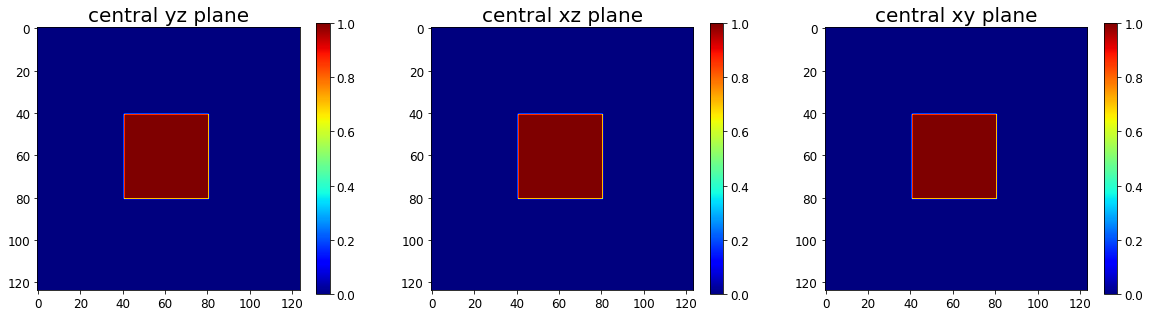

In [ ]:
# we adjust the shape of the problem to (124,124,124)
import numpy as np 
import math
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

dt = 0.1
dx = 1 
Dx = 200.0
Dy = 100.0
Dz = 50.0
# what are these terms in diff dimesions?
ub = 500 # what is this term? 

# the weights matrix (in 3D)
alpha = 1 # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 124
ny = 124
nz = 124

T = np.zeros([nx,ny,nz]) # problem space (128,128,128)
gamma = 10
# initialise t:
x0 = 0 
y0 = 0
z0 = 0
x = np.zeros([1,nx])
y = np.zeros([1,ny])
z = np.zeros([1,nz])

for i in range(40):
    for j in range(40):
        for k in range(40):
            T[i+41][j+41][k+41] = 1 

input_shape = (1,nx,ny,nz,1)
values = tf.zeros(input_shape)
print('values.shape: ', values.shape)

temp1 = tf.Variable(values)
temp1[0,:,:,:,0].assign(temp1[0,:,:,:,0]+tf.convert_to_tensor(T.astype('float32')))
values = temp1

# we can see the result is close to matrix size 64
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(values[0,:,:,61,0],cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(values[0,:,61,:,0],cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(values[0,61,:,:,0],cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Parallel multigrid 3D

In [ ]:
%%writefile parallel_multigrid_3D.py

#============================== Imports ==================================#
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import math
import time

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from mpi4py import MPI

# import the MPI subroutine
import halo_exchange

#============================== Initialization of original problem ==================================#
dx = 1       # Grid size in x    
dy = 1       # Grid size in y       
dz = 1       # Grid size in z    
Dx = 100.0   # Conductivity in x    
Dy = 100.0   # Conductivity in y
Dz = 100.0   # Conductivity in z
# Parameters for the computational domain
alpha = 1    # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 128     # Grid point in x
ny = 128     # Grid point in y
nz = 128     # Grid point in z

# cut the shape to (124,124,124) so we can divide the shape to 8 subdomains (62+2, 62+2, 62+2)

# the weights matrix
w1 = np.zeros([1,2,2,2,1])
w2 = np.zeros([1,3,3,3,1])
w1[0,:,:,:,0] = 0.125
pd1 = [[0.0, 0.0,  0.0],
       [0.0, 1.0*Dz/dz**2,  0.0],
       [0.0, 0.0,  0.0]]
pd2 = [[0.0, 1.0*Dy/dy**2,  0.0],
       [1.0*Dx/dx**2,  -(2*Dx/dx**2+2*Dy/dy**2+2*Dz/dz**2),  1.0*Dx/dx**2],
       [0.0, 1.0*Dy/dy**2,  0.0]]
pd3 = [[0.0, 0.0,  0.0],
       [0.0, 1.0*Dz/dz**2,  0.0],
       [0.0, 0.0,  0.0]]
w2[0,0,:,:,0] = -np.array(pd1) 
w2[0,1,:,:,0] = -np.array(pd2) 
w2[0,2,:,:,0] = -np.array(pd3) 

T = np.zeros([nx,ny,nz]) # original problem space (128,128,128)
gamma = 10
# initialise t:
x0 = 0 
y0 = 0
z0 = 0
x = np.zeros([1,nx])
y = np.zeros([1,ny])
z = np.zeros([1,nz])

# generate the squared heat source
for i in range(38):
    for j in range(38):
        for k in range(38):
            T[i+44][j+44][k+44] = 1 

T = T[2:-2,2:-2,2:-2].reshape((1,124,124,124,1)) # cut the boundary

# get domain-decomposition  
sub_nx, sub_ny, sub_nz, current_domain = halo_exchange.domain_decomposition_3D(T, 124, 124, 124) # calling MPI subroutine
sub_x, sub_y, sub_z = sub_nx + 2,sub_ny + 2,sub_nz + 2 # the padding shape += 2

input_shape = (1,sub_x,sub_y,sub_z,1)
values = tf.zeros(input_shape,tf.float32)
print(input_shape)

rank = halo_exchange.rank # get the process rank

# update halo once as the start
current_domain = halo_exchange.structured_halo_update_3D(tf.convert_to_tensor(current_domain))
current_domain = current_domain.numpy().reshape(sub_x, sub_y, sub_z)

np.save("/content/sub_domains/sub_domain_{}.npy".format(rank), current_domain)

#============================== Initialization CNN layers ==================================#
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)) )

# CNN layers
CNN3D_A_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer)
])

CNN3D_A_66 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(66, 66, 66, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_34 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(34, 34, 34, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_18 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(18, 18, 18, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_10 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(10, 10, 10, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_6 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(6, 6, 6, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_3 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(3, 3, 3, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

#============================== Restriction process ==================================#

CNN3D_res_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),   
])    

CNN3D_res_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_res_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])


#============================== Prolongation process ==================================#
CNN3D_prol_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

CNN3D_prol_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)), 
])

CNN3D_prol_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

CNN3D_prol_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

#============================== Skipping layer ==================================#
start_time = MPI.Wtime()

# F-cycle multigrid method
temp1 = tf.Variable(values)
temp1[0,:,:,:,0].assign(temp1[0,:,:,:,0]+tf.convert_to_tensor(current_domain.astype('float32'))) # for parallel we add subdomain
values = temp1

b = values # only for one time step
multi_itr = 100
j_itr = 1 # Jacobi iteration number

comm = halo_exchange.comm

# halo-update at each Jacobi iteration
for multi_grid in range(multi_itr):
    w = np.zeros([1,1,1,1,1])
    r = CNN3D_A_64(values) - b # compute the residual

    r = halo_exchange.structured_halo_update_3D(r) # need update the residual here

    # r_64 = CNN3D_res_128(r) 
    r_32 = CNN3D_res_64(r) # 128
    r_16 = CNN3D_res_32(r_32) # 64
    r_8 = CNN3D_res_16(r_16) # 32
    r_4 = CNN3D_res_8(r_8) # 16
    r_2 = CNN3D_res_4(r_4) # 8
    r_1 = CNN3D_res_2(r_2) # 4

    # we cannot go down anymore ...? 
    # so it is (2,2,2) coarse grid of original problem

    # I suppose here is the proess of Jacobi smoothing followed by prolongation (and correction)
    for Jacobi in range(j_itr):
        w = w - CNN3D_A_1(w)/w2[0,1,1,1,0] + r_1/w2[0,1,1,1,0]

    w_2 = CNN3D_prol_1(w)
    w_t1 = halo_exchange.padding_block_halo_3D(w_2,1)
    w_t1 = halo_exchange.structured_halo_update_3D(w_t1)
    for Jacobi in range(j_itr):
      temp = CNN3D_A_4(w_t1)
      w_2 = w_2 - temp/w2[0,1,1,1,0] + r_2/w2[0,1,1,1,0]

    w_4 = CNN3D_prol_2(w_2)
    w_t2 = halo_exchange.padding_block_halo_3D(w_4,1)
    w_t2 = halo_exchange.structured_halo_update_3D(w_t2)
    for Jacobi in range(j_itr):
      temp = CNN3D_A_6(w_t2)
      w_4 = w_4 - temp/w2[0,1,1,1,0] + r_4/w2[0,1,1,1,0]

    w_8 = CNN3D_prol_4(w_4)
    w_t3 = halo_exchange.padding_block_halo_3D(w_8,1)
    w_t3 = halo_exchange.structured_halo_update_3D(w_t3)
    for Jacobi in range(j_itr):
      temp = CNN3D_A_10(w_t3)
      w_8 = w_8 - temp/w2[0,1,1,1,0] + r_8/w2[0,1,1,1,0]

    w_16 = CNN3D_prol_8(w_8)
    w_t4 = halo_exchange.padding_block_halo_3D(w_16,1)
    w_t4 = halo_exchange.structured_halo_update_3D(w_t4)  
    for Jacobi in range(j_itr):
      temp = CNN3D_A_18(w_t4)
      w_16 = w_16 - temp/w2[0,1,1,1,0] + r_16/w2[0,1,1,1,0]

    w_32 = CNN3D_prol_16(w_16) 
    w_t5 = halo_exchange.padding_block_halo_3D(w_32,1)
    w_t5 = halo_exchange.structured_halo_update_3D(w_t5)  
    for Jacobi in range(j_itr):
      temp = CNN3D_A_34(w_t5)
      w_32 = w_32 - temp/w2[0,1,1,1,0] + r_32/w2[0,1,1,1,0]

    # w_64 = CNN3D_prol_32(w_32)
    # for Jacobi in range(j_itr):
    #     w_64 = w_64 - CNN3D_A_64(w_64)/w2[0,1,1,1,0] + r_64/w2[0,1 ,1,1,0]
    #     w_64 = parallel_halo_update.structured_halo_update_3D(tf.reshape(w_32, (32,32,32)))

    w_64 = CNN3D_prol_32(w_32) 
    w_t6 = halo_exchange.padding_block_halo_3D(w_64,1)
    w_t6 = halo_exchange.structured_halo_update_3D(w_t6)  
    for Jacobi in range(j_itr):
      temp = CNN3D_A_66(w_t6)
      w_64 = w_64 - temp/w2[0,1,1,1,0] + r/w2[0,1,1,1,0]

    values = values - w_64
    values = values - CNN3D_A_64(values)/w2[0,1,1,1,0] + b/w2[0,1,1,1,0]
    values = halo_exchange.structured_halo_update_3D(values) # need to update the values at the end of each multi-grid iteration
    
    if rank == 0:
     print(multi_grid)

end_time = MPI.Wtime()

# save final result and the prolongations (residual on different grids)
np.save("/content/parallel_output/parallel_AD_multigrid_3D_result_proc_{}.npy".format(rank),values)
np.save("/content/parallel_output/parallel_AD_multigrid_3D_w_proc_{}.npy".format(rank),w)
np.save("/content/parallel_output/parallel_AD_multigrid_3D_w2_proc_{}.npy".format(rank),w_2)
np.save("/content/parallel_output/parallel_AD_multigrid_3D_w4_proc_{}.npy".format(rank),w_4)
np.save("/content/parallel_output/parallel_AD_multigrid_3D_w8_proc_{}.npy".format(rank),w_8)
np.save("/content/parallel_output/parallel_AD_multigrid_3D_w16_proc_{}.npy".format(rank),w_16)
np.save("/content/parallel_output/parallel_AD_multigrid_3D_w32_proc_{}.npy".format(rank),w_32)
np.save("/content/parallel_output/parallel_AD_multigrid_3D_w64_proc_{}.npy".format(rank),w_64)
# # np.save("/content/output/serial_AD_multigrid_3D_w128.npy",w_128)

print(f"[INFO] Problem solved in {end_time - start_time:0.4f} seconds using parallel multigrid.")

Writing parallel_multigrid_3D.py


## Run the parallel code

In [ ]:
! mpiexec --allow-run-as-root -n 8 python parallel_multigrid_3D.py

2022-08-29 17:27:11.542728: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(1, 64, 64, 64, 1)
2022-08-29 17:27:11.719847: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-29 17:27:11.724956: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(1, 64, 64, 64, 1)
(1, 64, 64, 64, 1)
2022-08-29 17:27:11.763239: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
(1, 64, 64, 64, 1)
2022-08-29 17:27:11.784139: W tensorflow/core/common

## Check the overall residual

In [ ]:
print("GROUND-TRUTH:",res.reshape(2,2,2))

In [ ]:
print("PARALLEL:",parallel_res.reshape(2,2,2))

## Detail visualization

In [ ]:
sub_domain1 = np.load("/content/sub_domains/sub_domain_0.npy")
sub_domain2 = np.load("/content/sub_domains/sub_domain_1.npy")
sub_domain3 = np.load("/content/sub_domains/sub_domain_2.npy")
sub_domain4 = np.load("/content/sub_domains/sub_domain_3.npy")
sub_domain5 = np.load("/content/sub_domains/sub_domain_4.npy")
sub_domain6 = np.load("/content/sub_domains/sub_domain_5.npy")
sub_domain7 = np.load("/content/sub_domains/sub_domain_6.npy")
sub_domain8 = np.load("/content/sub_domains/sub_domain_7.npy")

temp1 = np.concatenate([sub_domain1,sub_domain2], axis = 2)
temp2 = np.concatenate([sub_domain3,sub_domain4], axis = 2)
level_1 = np.concatenate([temp1, temp2], axis = 1)

temp3 = np.concatenate([sub_domain5,sub_domain6], axis = 2)
temp4 = np.concatenate([sub_domain7,sub_domain8], axis = 2)
level_2 = np.concatenate([temp3, temp4], axis = 1)

merged_domain = np.concatenate([level_1,level_2], axis=0)
print(merged_domain.shape)

plot_cube(merged_domain.reshape(1,128,128,128,1),63)
# plt.imshow(sub_domain4[62,:,:20])
# plt.imshow(sub_domain4[:2,:2,63])
# plt.imshow(sub_domain4[63,:2,:2])

## Validate the halo update

In [ ]:
## validate the initial subdomain
subdomain_1 = np.load("/content/sub_domains/sub_domain_0.npy")
subdomain_2 = np.load("/content/sub_domains/sub_domain_1.npy")
subdomain_3 = np.load("/content/sub_domains/sub_domain_2.npy")
subdomain_4 = np.load("/content/sub_domains/sub_domain_3.npy")
subdomain_5 = np.load("/content/sub_domains/sub_domain_4.npy")
subdomain_6 = np.load("/content/sub_domains/sub_domain_5.npy")
subdomain_7 = np.load("/content/sub_domains/sub_domain_6.npy")
subdomain_8 = np.load("/content/sub_domains/sub_domain_7.npy")

subdomain_4.shape

In [ ]:
temp1 = np.concatenate([subdomain_1,subdomain_2], axis = 2)
temp2 = np.concatenate([subdomain_3,subdomain_4], axis = 2)
level_1 = np.concatenate([temp1, temp2], axis = 1)

temp3 = np.concatenate([subdomain_5,subdomain_6], axis = 2)
temp4 = np.concatenate([subdomain_7,subdomain_8], axis = 2)
level_2 = np.concatenate([temp3, temp4], axis = 1)

domain = np.concatenate([level_1,level_2], axis=0)

print(domain.shape)

fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(domain[:,:,61], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(domain[:,61,:], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(domain[61,:,:], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

In [ ]:
right_halo_0 = subdomain_1[:,:,-1] # from process 1
behind_halo_0 = subdomain_2[:,-1,:] # from process 2
top_halo_0 = subdomain_4[-1,:,:] # from process 4

fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(right_halo_0)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(behind_halo_0)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(top_halo_0)
plt.colorbar()

# top_halo_0[-1,:]

In [ ]:
left_send_1 = subdomain_1[:,:,1] 
front_send_2 = subdomain_2[:,1,:] 
bottom_send_4 = subdomain_4[1,:,:] 

fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(left_send_1)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(front_send_2)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(bottom_send_4)
plt.colorbar()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,2,1)
plt.imshow(subdomain_0[-1,:,:])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(subdomain_0[-2,:,:])
plt.colorbar()

## Visualization of the result

In [ ]:
# Load the result

# serial
serial_solution = np.load("/content/serial_output/serial_AD_multigrid_3D_result.npy")
w_2 = np.load("/content/serial_output/serial_AD_multigrid_3D_w2.npy")
w_4 = np.load("/content/serial_output/serial_AD_multigrid_3D_w4.npy")
w_8 = np.load("/content/serial_output/serial_AD_multigrid_3D_w8.npy")
w_16 = np.load("/content/serial_output/serial_AD_multigrid_3D_w16.npy")
w_32 = np.load("/content/serial_output/serial_AD_multigrid_3D_w32.npy")
serial_w_64 = np.load("/content/serial_output/serial_AD_multigrid_3D_w64.npy")
serial_w_128 = np.load("/content/serial_output/serial_AD_multigrid_3D_w128.npy")

# parallel
pval_1 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_result_proc_0.npy")
pval_2 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_result_proc_1.npy")
pval_3 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_result_proc_2.npy")
pval_4 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_result_proc_3.npy")
pval_5 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_result_proc_4.npy")
pval_6 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_result_proc_5.npy")
pval_7 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_result_proc_6.npy")
pval_8 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_result_proc_7.npy")

# pval_1.shape

## Merge the parallel result

In [ ]:
test1 = np.concatenate([pval_1,pval_2], axis = 3)
test2 = np.concatenate([pval_3,pval_4], axis = 3)
level_1 = np.concatenate([test1, test2], axis = 2)

print(level_1.shape)

test3 = np.concatenate([pval_5,pval_6], axis = 3)
test4 = np.concatenate([pval_7,pval_8], axis = 3)
level_2 = np.concatenate([test3, test4], axis = 2)

print(level_2.shape)

parallel_solution = np.concatenate([level_1,level_2], axis=1)
# parallel_solution = parallel_solution.reshape(1,124,124,124,1)
parallel_solution = parallel_solution.reshape(1,128,128,128,1)
parallel_solution.shape

(1, 64, 128, 128, 1)
(1, 64, 128, 128, 1)


(1, 128, 128, 128, 1)

## Serial 2x2 residual

Text(0.5, 1.0, 'central xy plane')

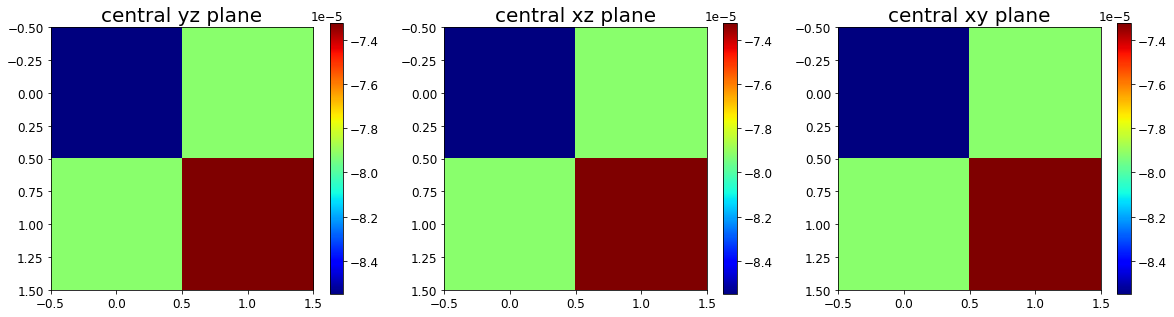

In [ ]:
# Here we will check the solution of w4,8,16,32,64,128 prolongation
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_2[0,:,:,0,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_2[0,:,0,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_2[0,0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

## Parallel 2x2

(1, 2, 2, 2, 1)


Text(0.5, 1.0, 'central xy plane')

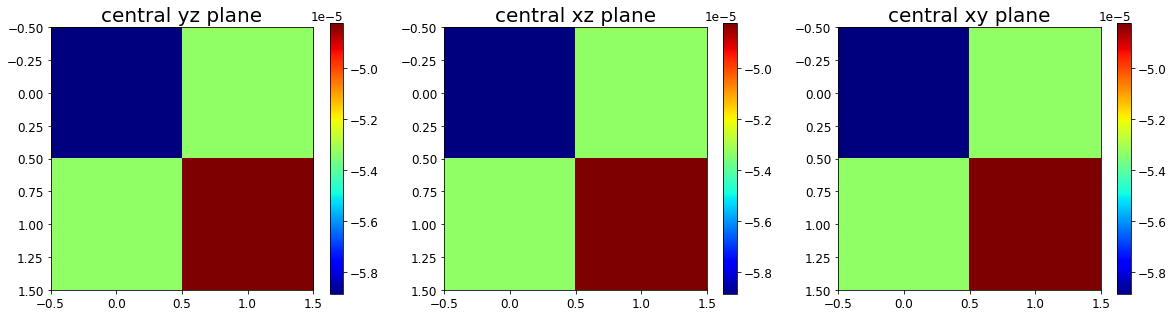

In [ ]:
w4_1 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w_proc_0.npy")
w4_2 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w_proc_1.npy")
w4_3 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w_proc_2.npy")
w4_4 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w_proc_3.npy")
w4_5 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w_proc_4.npy")
w4_6 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w_proc_5.npy")
w4_7 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w_proc_6.npy")
w4_8 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w_proc_7.npy")

test1 = np.concatenate([w4_1,w4_2], axis = 3)
test2 = np.concatenate([w4_3,w4_4], axis = 3)
level_1 = np.concatenate([test1, test2], axis = 2)

test3 = np.concatenate([w4_5,w4_6], axis = 3)
test4 = np.concatenate([w4_7,w4_8], axis = 3)
level_2 = np.concatenate([test3, test4], axis = 2)

parallel_8_res = np.concatenate([level_1,level_2], axis=1)
print(parallel_8_res.shape)

fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(parallel_8_res[0,:,:,0,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(parallel_8_res[0,:,0,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(parallel_8_res[0,0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

## Parallel 4x4 residual

(1, 4, 4, 4, 1)


Text(0.5, 1.0, 'central xy plane')

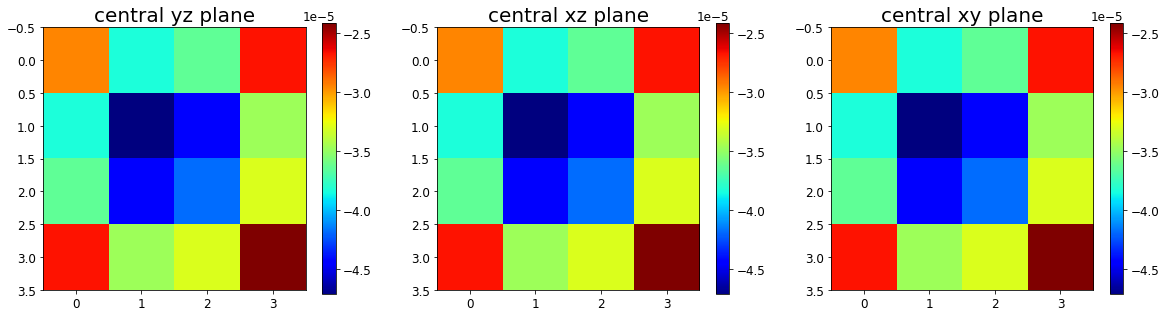

In [ ]:
w4_1 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w2_proc_0.npy")
w4_2 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w2_proc_1.npy")
w4_3 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w2_proc_2.npy")
w4_4 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w2_proc_3.npy")
w4_5 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w2_proc_4.npy")
w4_6 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w2_proc_5.npy")
w4_7 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w2_proc_6.npy")
w4_8 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w2_proc_7.npy")

test1 = np.concatenate([w4_1,w4_2], axis = 3)
test2 = np.concatenate([w4_3,w4_4], axis = 3)
level_1 = np.concatenate([test1, test2], axis = 2)

test3 = np.concatenate([w4_5,w4_6], axis = 3)
test4 = np.concatenate([w4_7,w4_8], axis = 3)
level_2 = np.concatenate([test3, test4], axis = 2)

parallel_8_res = np.concatenate([level_1,level_2], axis=1)
print(parallel_8_res.shape)

fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(parallel_8_res[0,:,:,0,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(parallel_8_res[0,:,0,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(parallel_8_res[0,0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

## Serial 4x4 residual

Text(0.5, 1.0, 'central xy plane')

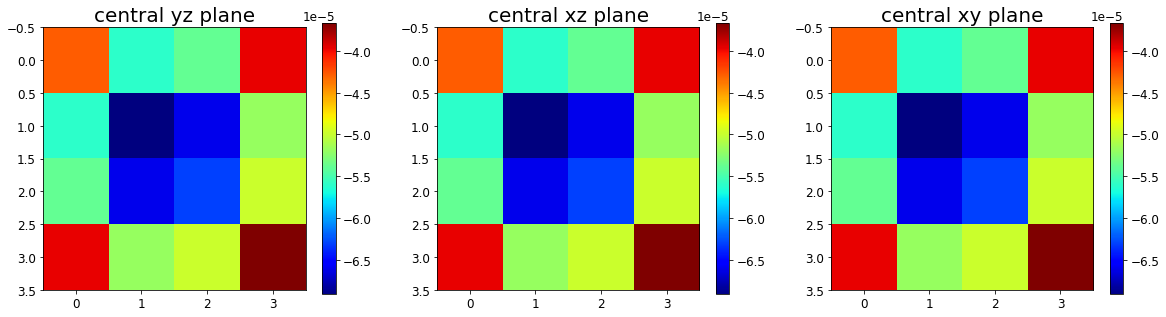

In [ ]:
# Here we will check the solution of w4,8,16,32,64,128 prolongation
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_4[0,:,:,0,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_4[0,:,0,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_4[0,0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

## Parallel 8x8 residual

(1, 8, 8, 8, 1)


Text(0.5, 1.0, 'central xy plane')

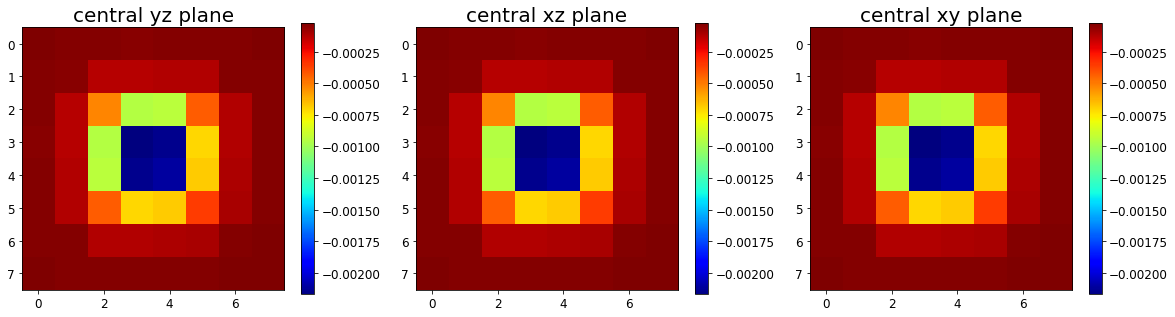

In [ ]:
w4_1 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w4_proc_0.npy")
w4_2 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w4_proc_1.npy")
w4_3 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w4_proc_2.npy")
w4_4 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w4_proc_3.npy")
w4_5 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w4_proc_4.npy")
w4_6 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w4_proc_5.npy")
w4_7 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w4_proc_6.npy")
w4_8 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w4_proc_7.npy")

test1 = np.concatenate([w4_1,w4_2], axis = 3)
test2 = np.concatenate([w4_3,w4_4], axis = 3)
level_1 = np.concatenate([test1, test2], axis = 2)

test3 = np.concatenate([w4_5,w4_6], axis = 3)
test4 = np.concatenate([w4_7,w4_8], axis = 3)
level_2 = np.concatenate([test3, test4], axis = 2)

parallel_8_res = np.concatenate([level_1,level_2], axis=1)
print(parallel_8_res.shape)

fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(parallel_8_res[0,:,:,3,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(parallel_8_res[0,:,3,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(parallel_8_res[0,3,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

## Serial 8x8 residual

Text(0.5, 1.0, 'central xy plane')

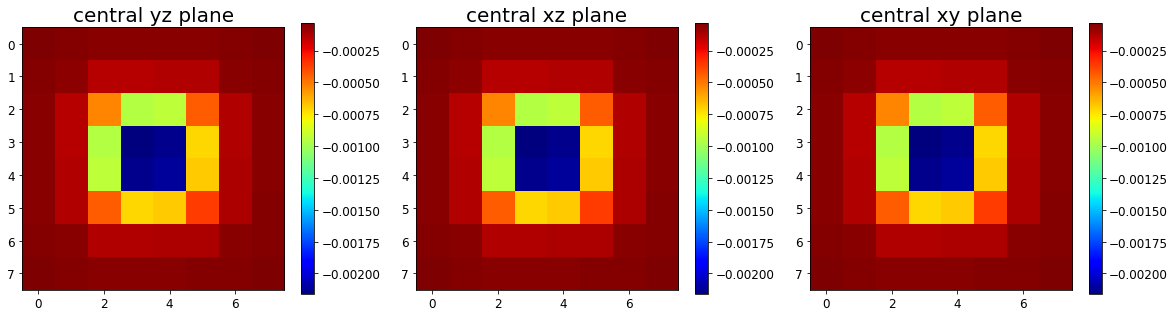

In [ ]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_8[0,:,:,4,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_8[0,:,4,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_8[0,4,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

In [ ]:
w_8.shape
parallel_8_res.shape
print(np.sum(np.abs(w_8 - parallel_8_res)))

0.008680558


## Serial 16x16 residual

Text(0.5, 1.0, 'central xy plane')

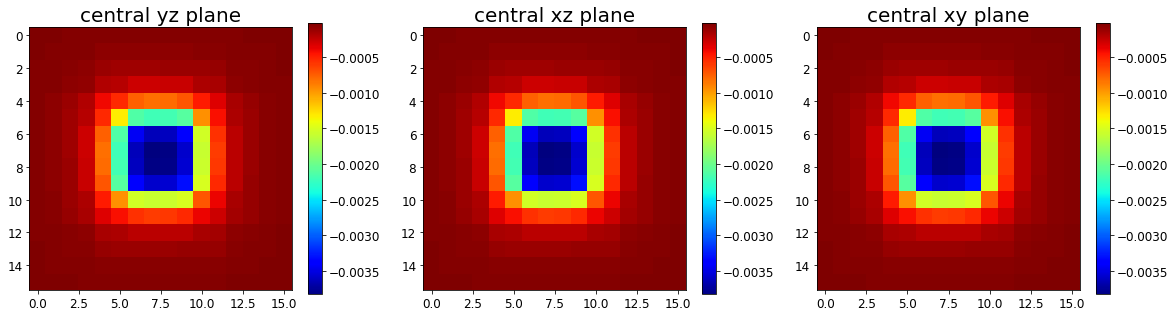

In [ ]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_16[0,:,:,8,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_16[0,:,8,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_16[0,8,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

## Serial 32x32 residual

Text(0.5, 1.0, 'central xy plane')

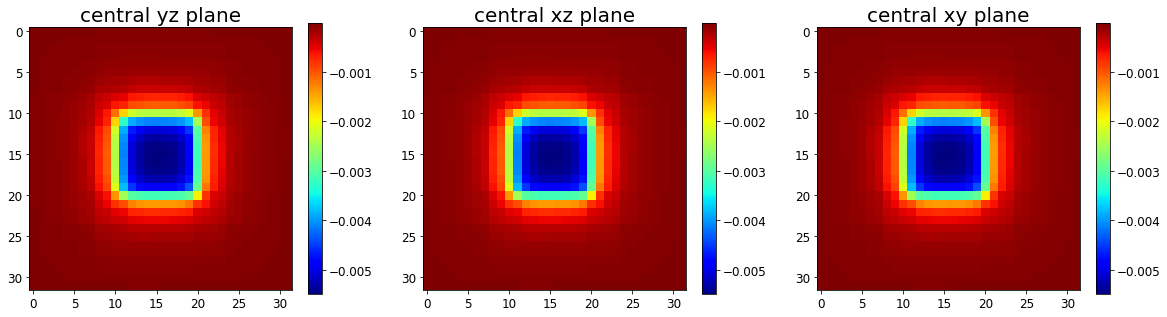

In [ ]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_32[0,:,:,16,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_32[0,:,16,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_32[0,16,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

## Serial 64x64 residual

(1, 64, 64, 64, 1)

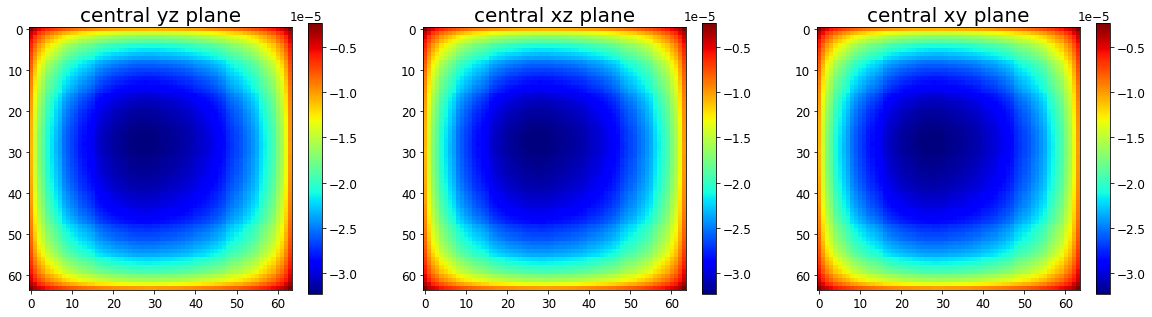

In [ ]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(serial_w_64[0,:,:,0,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(serial_w_64[0,:,0,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(serial_w_64[0,0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)
serial_w_64.shape

## Parallel 64x64 residual

(64, 64, 64)


Text(0.5, 1.0, 'central xy plane')

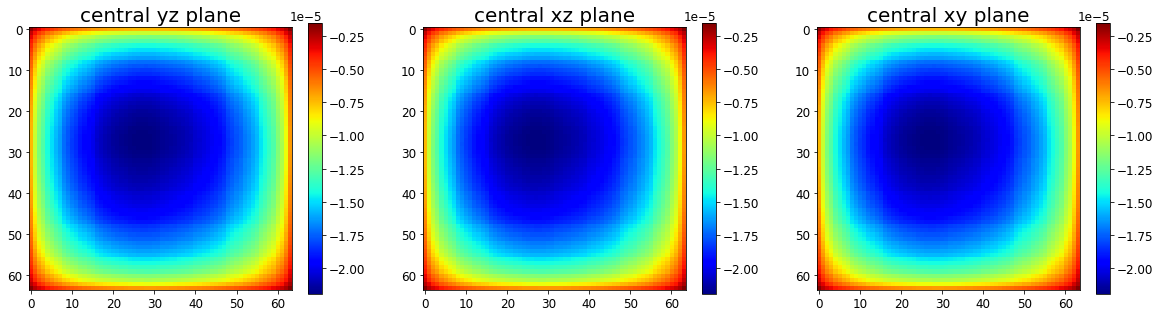

In [ ]:
w32_1 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w32_proc_0.npy")
w32_2 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w32_proc_1.npy")
w32_3 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w32_proc_2.npy")
w32_4 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w32_proc_3.npy")
w32_5 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w32_proc_4.npy")
w32_6 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w32_proc_5.npy")
w32_7 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w32_proc_6.npy")
w32_8 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w32_proc_7.npy")

# todo: merge the 64 residual into 128 grid residual
temp1 = np.concatenate([w32_1,w32_2], axis = 3)
temp2 = np.concatenate([w32_3,w32_4], axis = 3)
level_1 = np.concatenate([temp1, temp2], axis = 2)

temp3 = np.concatenate([w32_5,w32_6], axis = 3)
temp4 = np.concatenate([w32_7,w32_8], axis = 3)
level_2 = np.concatenate([temp3, temp4], axis = 2)

r_parallel_64 = np.concatenate([level_1,level_2], axis=1)

# print(r_parallel_64.shape)
# print(w32_1.shape)
# r_parallel_64 = r_parallel_64[0, 1:-1,1:-1,1:-1,0]
r_parallel_64 = r_parallel_64[0,:,:,:,0]
print(r_parallel_64.shape)


fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(r_parallel_64[:,:,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(r_parallel_64[:,0,:], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(r_parallel_64[0,:,:], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)
# w64_1[0,31,-2:-1,-2:-1,0].shape

## Serial 128x128 residual

Text(0.5, 1.0, 'central xy plane')

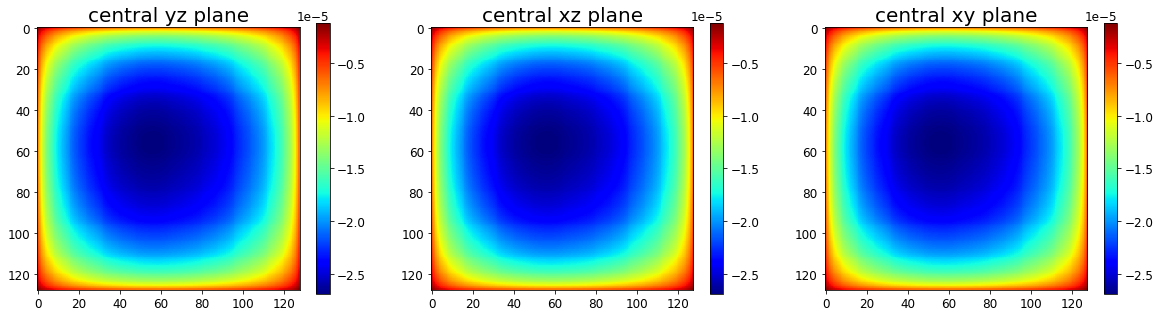

In [ ]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(serial_w_128[0,:,:,0,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(serial_w_128[0,:,0,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(serial_w_128[0,0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

## Parallel 128x128 residual

(128, 128, 128)


Text(0.5, 1.0, 'central xy plane')

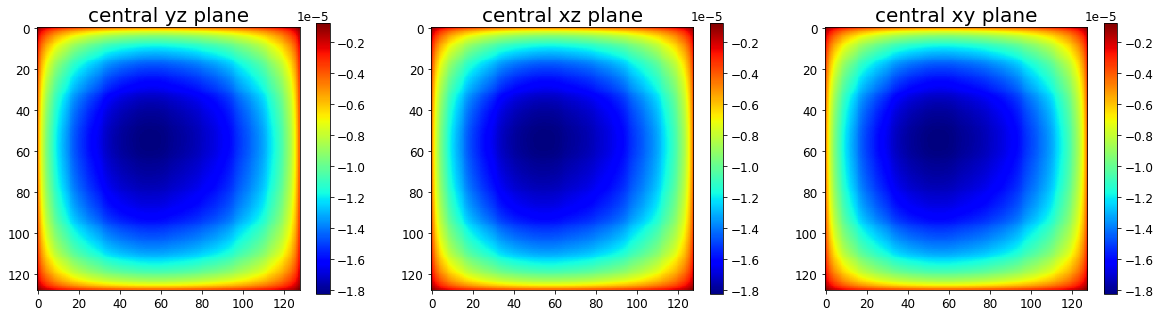

In [ ]:
w64_1 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w64_proc_0.npy")
w64_2 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w64_proc_1.npy")
w64_3 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w64_proc_2.npy")
w64_4 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w64_proc_3.npy")
w64_5 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w64_proc_4.npy")
w64_6 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w64_proc_5.npy")
w64_7 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w64_proc_6.npy")
w64_8 = np.load("/content/parallel_output/parallel_AD_multigrid_3D_w64_proc_7.npy")


# todo: merge the 64 residual into 128 grid residual
temp1 = np.concatenate([w64_1,w64_2], axis = 3)
temp2 = np.concatenate([w64_3,w64_4], axis = 3)
level_1 = np.concatenate([temp1, temp2], axis = 2)

temp3 = np.concatenate([w64_5,w64_6], axis = 3)
temp4 = np.concatenate([w64_7,w64_8], axis = 3)
level_2 = np.concatenate([temp3, temp4], axis = 2)

r_parallel_128 = np.concatenate([level_1,level_2], axis=1)

# print(r_parallel_128.shape)
# r_parallel_128 = r_parallel_128[0,1:-1,1:-1,1:-1,0]
r_parallel_128 = r_parallel_128[0,:,:,:,0]
print(r_parallel_128.shape)


fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(r_parallel_128[:,:,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(r_parallel_128[:,0,:], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(r_parallel_128[0,:,:], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)
# w64_1[0,31,-2:-1,-2:-1,0].shape

## Serial solution

(1, 128, 128, 128, 1)

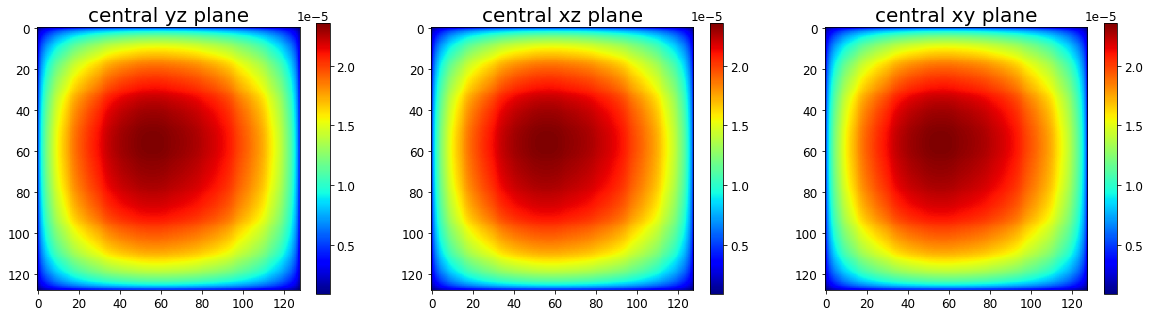

In [ ]:
# we can see the result is close to matrix size 64
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(serial_solution[0,:,:,0,0],cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(serial_solution[0,:,0,:,0],cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(serial_solution[0,0,:,:,0],cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)
serial_solution.shape

## Parallel solution

(1, 128, 128, 128, 1)


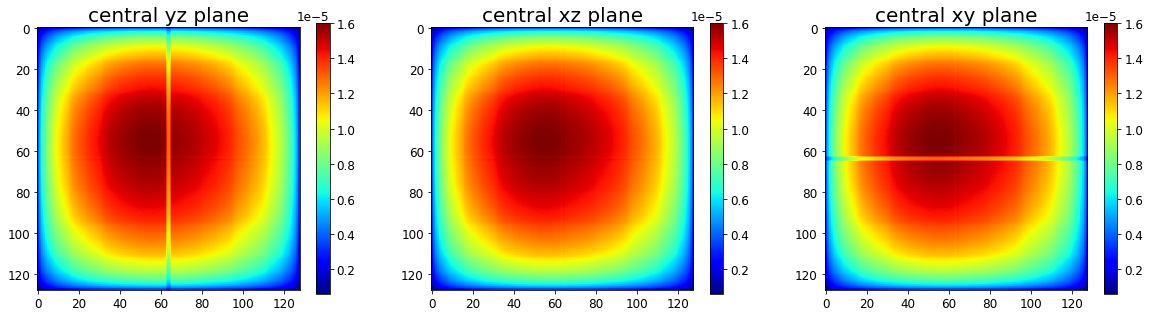

In [ ]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(parallel_solution[0,:,:,0,0],cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(parallel_solution[0,:,0,:,0],cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(parallel_solution[0,0,:,:,0],cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

print(parallel_solution.shape)

In [ ]:
serial_r = np.load("/content/residual/serial_residual.npy")
serial_r = serial_r[0,2:-2,2:-2,2:-2,0].reshape(1,124,124,124,1)

# we can see the result is close to matrix size 64
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(serial_r[0,:,:,61,0],cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(serial_r[0,:,61,:,0],cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(serial_r[0,61,:,:,0],cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)
serial_r.shape

FileNotFoundError: ignored

In [ ]:
p_r_1 = np.load("/content/residual/parallel_residual_0.npy")
p_r_2 = np.load("/content/residual/parallel_residual_1.npy")
p_r_3 = np.load("/content/residual/parallel_residual_2.npy")
p_r_4 = np.load("/content/residual/parallel_residual_3.npy")
p_r_5 = np.load("/content/residual/parallel_residual_4.npy")
p_r_6 = np.load("/content/residual/parallel_residual_5.npy")
p_r_7 = np.load("/content/residual/parallel_residual_6.npy")
p_r_8 = np.load("/content/residual/parallel_residual_7.npy")

p_r_1 = p_r_1[0,1:-1,1:-1,1:-1,0].reshape(1,62,62,62,1)
p_r_2 = p_r_2[0,1:-1,1:-1,1:-1,0].reshape(1,62,62,62,1)
p_r_3 = p_r_3[0,1:-1,1:-1,1:-1,0].reshape(1,62,62,62,1)
p_r_4 = p_r_4[0,1:-1,1:-1,1:-1,0].reshape(1,62,62,62,1)
p_r_5 = p_r_5[0,1:-1,1:-1,1:-1,0].reshape(1,62,62,62,1)
p_r_6 = p_r_6[0,1:-1,1:-1,1:-1,0].reshape(1,62,62,62,1)
p_r_7 = p_r_7[0,1:-1,1:-1,1:-1,0].reshape(1,62,62,62,1)
p_r_8 = p_r_8[0,1:-1,1:-1,1:-1,0].reshape(1,62,62,62,1)

test1 = np.concatenate([p_r_1,p_r_2], axis = 3)
test2 = np.concatenate([p_r_3,p_r_4], axis = 3)
level_1 = np.concatenate([test1, test2], axis = 2)

test3 = np.concatenate([p_r_5,p_r_6], axis = 3)
test4 = np.concatenate([p_r_7,p_r_8], axis = 3)
level_2 = np.concatenate([test3, test4], axis = 2)

parallel_r = np.concatenate([level_1,level_2], axis=1)
parallel_r.shape

# we can see the result is close to matrix size 64
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(parallel_r[0,:,:,61,0],cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(parallel_r[0,:,61,:,0],cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(parallel_r[0,61,:,:,0],cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)
parallel_solution.shape

In [ ]:
assert serial_r.all() == parallel_r.all()

In [ ]:
import numpy as np

# a = serial_solution[0,2:-2,2:-2,2:-2,0]
a = serial_solution
# plt.imshow(a[61,:,:],cmap='jet')
# plt.colorbar()

print("ABE of subdomains: ", np.abs(np.sum(a) - np.sum(parallel_solution))/(128*128*128))

from numpy import linalg as LA
serial_l1 = LA.norm(a)
parallel_l1 = LA.norm(parallel_solution)

# diffs between norm values
print(serial_l1)
print(parallel_l1)
print("ABE of norms: ",np.abs(serial_l1 - parallel_l1))
print("Average ABE of norms: ",np.abs(serial_l1 - parallel_l1)/(128*128*128))

ABE of subdomains:  0.0023836642503738403
288.47165
281.94656
ABE of norms:  6.5250854
Average ABE of norms:  3.11140320263803e-06
